# Personalised Sound Meter

The goal of this notebook is to create a sound meter that can measure the RMS level of a given audio file, taking into account a user-defined equal-loudness curve.

The notebook was created a miniproject for the [COM-418 Computers and music] course at EPFL.

Author: Juraj Mičko

## Loading the audio sample

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
from scipy import signal
from scipy.io import wavfile
import ipywidgets as widgets
import json
import scipy

In [2]:
filename = "Vein drive (cut).wav"
iff_sf, iff = wavfile.read(filename)
iff = iff.T.astype(np.float64) / np.max(np.abs(iff))
print(iff.shape)
print("Duration: {:.1f}s".format(iff.shape[1]/iff_sf))
DEFAULT_SF = iff_sf

(2, 720000)
Duration: 15.0s


*Note: the audio file is a cut from a song produced by me (https://soundcloud.com/jjurm/vein-drive). It is cut due to its length and large file size.*

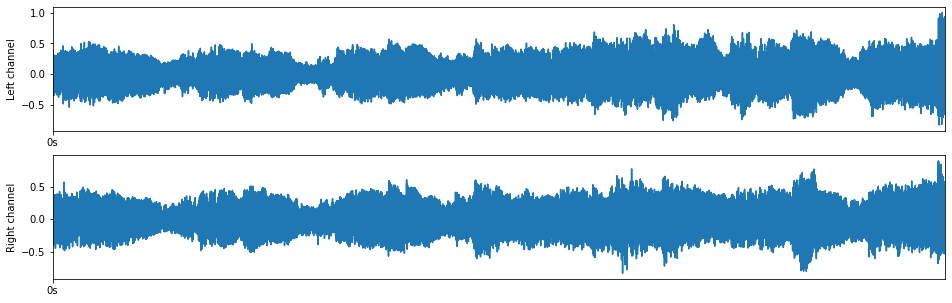

In [3]:
def plot_waveform(iff, iff_sf):
    if len(iff.shape) == 2:
        fig = plt.figure(figsize=(16,5))
        ax1 = plt.subplot(211)
        ax1.plot(iff[0])
        ax1.set_ylabel("Left channel")
        ax1.set_xlim((0,iff.shape[1]))
        ax1.set_xticks(np.arange(0, iff.shape[1], iff_sf*30))
        ax1.set_xticklabels(list(map(lambda t: "{:.0f}s".format(t), np.arange(0, iff.shape[1]/iff_sf, 30))))
        ax2 = plt.subplot(212, sharex = ax1)
        ax2.plot(iff[1])
        ax2.set_ylabel("Right channel")
    else:
        fig = plt.figure(figsize=(16,2.5))
        ax1 = plt.subplot(111)
        ax1.plot(iff)
        ax1.set_xlim((0,iff.shape[0]))
        ax1.set_xticks(np.arange(0, iff.shape[0], iff_sf*30))
        ax1.set_xticklabels(list(map(lambda t: "{:.0f}s".format(t), np.arange(0, iff.shape[0]/iff_sf, 30))))

plot_waveform(iff, iff_sf)

In [4]:
def declick(x, sf=DEFAULT_SF):
    TAPER = int(0.01 * sf)
    y = np.copy(x)
    y[:TAPER] *= np.linspace(0, 1, TAPER)
    y[-TAPER:] *= np.linspace(1, 0, TAPER)
    return y


class InvisibleAudio(Audio):
    def _repr_html_(self):
        audio = super()._repr_html_()
        audio = audio.replace('<audio', f'<audio onended="this.parentNode.removeChild(this)"')
        return f'<div style="display:none">{audio}</div>'

def play(x, sf=DEFAULT_SF, normalize=False):
    return Audio(declick(x, sf=sf), rate=sf, normalize=normalize)
def play_invisible(x, sf=DEFAULT_SF, normalize=False):
    return InvisibleAudio(declick(x, sf=sf), rate=sf, autoplay=True, normalize=normalize)

In [5]:
Audio(iff, rate=iff_sf)

In [6]:
# Use only the left channel
play(iff[0], normalize=True)

##  The Psychoacoustic Experiment


In [7]:
duration = 2

def sine(freq=1000, duration=2, gain=-3, sf=DEFAULT_SF):
    x = np.arange(0, np.pi*2 * duration * freq, np.pi*2 / sf * freq)
    y = np.sin(x) * (10 ** (gain / 20))
    return y

In [8]:
def freq_to_str(freq):
    return "{:.0f}".format(freq) + " Hz"
def gain_to_str(gain):
    return "{:.0f}".format(gain) + " dB SPL"

In [9]:
# Load recorded points from file if possible
recorded_points = []

def load_measurements():
    global recorded_points
    try:
        with open('measurements.json', 'r') as f:
            data = f.read()
            recorded_points = json.loads(data)
            print("Loaded "+str(len(recorded_points))+" measurements from 'measurements.json'.")
    except:
        print("File 'measurements.json' is missing, no measurements loaded.")
        pass

def save_measurements():
    global recorded_points
    with open('measurements.json', 'w') as f:
        data = json.dumps(recorded_points)
        f.write(data)
        print("Saved "+str(len(recorded_points))+" measurements to 'measurements.json'.")

In [10]:
min_frequency = 20
max_frequency = 15000
selected_frequency = 1000
min_gain = -140
max_gain = 12 # 4x higher amplitude than reference
default_gain = 0
reference_frequency = 1000
gain_offset = -15 # in dBFS, so user-defined signal has max -15+12=-3 dBFS
selected_gain = default_gain

In [11]:
freq_slider = widgets.FloatSlider(
    value=np.log10(selected_frequency),
    min=np.log10(min_frequency),
    max=np.log10(max_frequency),
    step=(np.log10(max_frequency)-np.log10(min_frequency))/500,
    description='Frequency:',
    readout=False,
    layout=widgets.Layout(width='500px')
)
freq_label = widgets.Label(
    value=freq_to_str(selected_frequency),
    layout=widgets.Layout(width='70px')
)
freq_random = widgets.Button(
    description=' Choose random',
    icon='random'
)

def on_freq_slider_change(change):
    global selected_frequency
    freq = 10 ** change['new']
    freq_label.value = freq_to_str(freq)
    selected_frequency = freq
freq_slider.observe(on_freq_slider_change, names='value')

def on_freq_random_click(b):
    #freq = 10 ** 
    freq_slider.value = np.random.uniform(np.log10(min_frequency), np.log10(max_frequency))
freq_random.on_click(on_freq_random_click)

#---

slider_gain = widgets.FloatSlider(
    value=selected_gain,
    min=min_gain,
    max=max_gain,
    step=(max_gain - min_gain)/500,
    description="Gain: ",
    readout=False,
    layout=widgets.Layout(width='500px')
)
slider_gain_label = widgets.Label(
    value=gain_to_str(selected_gain),
    layout=widgets.Layout(width='70px')
)
btn_reset_gain = widgets.Button(description=" Reset gain", icon="repeat")

def on_gain_slider_change(change):
    global selected_gain
    gain = change['new']
    slider_gain_label.value = gain_to_str(gain)
    selected_gain = gain
slider_gain.observe(on_gain_slider_change, names='value')

def on_reset_gain_click(b):
    slider_gain.value = default_gain
btn_reset_gain.on_click(on_reset_gain_click)

#---

out_widget = widgets.Output()
btn_play_reference = widgets.Button(description="Reference (1KHZ)", icon="play")
btn_play_selected = widgets.Button(description="Selected frequency", icon="play-circle")

def on_play_click_f(reference):
    global selected_frequency, selected_gain
    kwargs = {"duration": 2}
    def on_play_click(b):
        if reference:
            x = sine(freq=reference_frequency, gain=default_gain + gain_offset, **kwargs)
        else:
            x = sine(freq=selected_frequency, gain=selected_gain + gain_offset, **kwargs)
        out_widget.clear_output()
        with out_widget:
            display(play_invisible(x))
    return on_play_click
btn_play_reference.on_click(on_play_click_f(reference=True))
btn_play_selected.on_click(on_play_click_f(reference=False))

#---

btn_add_sample = widgets.Button(
    description="Record sample point",
    layout=widgets.Layout(width='170px'),
    icon="plus"
)
label_sample_point = widgets.Label(value="("+freq_to_str(selected_frequency)+", "+gain_to_str(selected_gain)+")")
label_info = widgets.Label(value="Total measurements: "+str(len(recorded_points)))

def on_add_sample_click(b):
    global recorded_points
    point = (selected_frequency, selected_gain)
    recorded_points.append(point)
    label_info.value = "Total measurements: "+str(len(recorded_points))
btn_add_sample.on_click(on_add_sample_click)

#---

btn_load_measurements = widgets.Button(
    description="Load measurements",
    icon="file-text-o",
    layout=widgets.Layout(width='170px')
)
def on_load_measurements_click(b):
    load_measurements()
    label_info.value = "Total measurements: "+str(len(recorded_points))
btn_load_measurements.on_click(on_load_measurements_click)
btn_save_measurements = widgets.Button(
    description="Save measurements",
    icon="floppy-o",
    layout=widgets.Layout(width='170px')
)
btn_save_measurements.on_click(lambda b: save_measurements())
btn_clear_measurements = widgets.Button(
    description="Clear measurements",
    icon="file-o",
    layout=widgets.Layout(width='170px')
)
def on_clear_measurements_click(b):
    global recorded_points
    recorded_points = []
    label_info.value = "Total measurements: "+str(len(recorded_points))
btn_clear_measurements.on_click(on_clear_measurements_click)

#---

widget = widgets.VBox([
    widgets.HBox([freq_slider, freq_label, freq_random]),
    widgets.HBox([slider_gain, slider_gain_label, btn_reset_gain]),
    widgets.HBox([btn_play_reference, btn_play_selected]),
    widgets.HBox([btn_add_sample, label_sample_point]),
    label_info,
    out_widget,
    widgets.HBox([btn_load_measurements, btn_save_measurements, btn_clear_measurements])
])

display(widget)

In [12]:
# automatically load measurements from file if available
on_load_measurements_click(None)

Loaded 20 measurements from 'measurements.json'.


In [13]:
def preprocess_recorded_points(data):
    if len(data) == 0:
        data = [[reference_frequency, default_gain]]
    data = np.array(data)
    # sort by increasing frequency
    data = data[data[:,0].argsort()]
    # add leftmost and rightmost points if needed
    left_freq, left_gain = data[0] if len(data) > 0 else default_gain
    right_freq, right_gain = data[-1] if len(data) > 0 else default_gain
    epsilon = 1e-07
    if min_frequency + epsilon < left_freq:
        data = np.concatenate([[[min_frequency, left_gain]], data])
    if max_frequency - epsilon > right_freq:
        data = np.concatenate([data, [[max_frequency, right_gain]]])
    return data

def plot_recorded_points(data, axis=None, color='C0'):
    if axis is None:
        _, axis = plt.subplots()
    axis.scatter(data[:,0], data[:,1], color=color)
    axis.plot(data[:,0], data[:,1], color=color)
    axis.set_xscale('log')
    axis.set_ylabel('dB SPL', color='C0')
    axis.set_xlabel('Hz')
    axis.grid(b=True, which='both')
    axis.axis('tight')
    axis.set_xlim([min_frequency-3, max_frequency+1000])
    axis.set_ylim([min(data[:,1])-6, max_gain+6])
    axis.set_title("Measured ear sensitivity\n(relative to the reference 1KHz tone)")

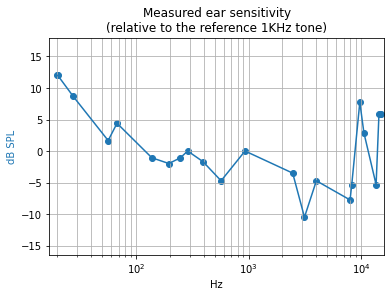

In [14]:
plot_recorded_points(preprocess_recorded_points(recorded_points))

##  The Weighting Filter



In [15]:
def create_filter(recorded_points, n_taps):
    data = preprocess_recorded_points(recorded_points)
    bands = []
    desired = []
    for ((band_l, gain_l), (band_r, gain_r)) in zip(data[:-1], data[1:]):
        bands.append(band_l)
        bands.append(band_r)
        desired.append(-gain_l)
        desired.append(-gain_r)
    print(bands)
    print(desired)
    taps = scipy.signal.firwin2(
        numtaps=n_taps,
        freq=np.concatenate([[0], data[:,0], [DEFAULT_SF/2]]),
        gain=np.concatenate([[0], data[:,1], [0]]),
        fs=DEFAULT_SF
    )
    return taps

n_taps = 100
taps = create_filter(recorded_points, n_taps)

[20.0, 20.199980922911944, 20.199980922911944, 27.74496578280085, 27.74496578280085, 56.61237059160823, 56.61237059160823, 67.90113861732868, 67.90113861732868, 138.36695219666697, 138.36695219666697, 196.04344532360562, 196.04344532360562, 248.04532304224966, 248.04532304224966, 287.8650923915421, 287.8650923915421, 393.5456853675385, 393.5456853675385, 570.3737060851848, 570.3737060851848, 930.3400455766874, 930.3400455766874, 2465.978530963005, 2465.978530963005, 3137.271722298469, 3137.271722298469, 4002.514918429579, 4002.514918429579, 7972.8487024507895, 7972.8487024507895, 8251.159486799215, 8251.159486799215, 9732.409523328826, 9732.409523328826, 10583.05743891633, 10583.05743891633, 13578.169432463214, 13578.169432463214, 14402.81291445544, 14402.81291445544, 15000.0]
[-12.0, -12.0, -12.0, -8.656, -8.656, -1.664, -1.664, -4.4, -4.4, 1.072, 1.072, 1.984, 1.984, 1.072, 1.072, -0.0, -0.0, 1.68, 1.68, 4.72, 4.72, -0.0, -0.0, 3.504, 3.504, 10.496, 10.496, 4.72, 4.72, 7.76, 7.76, 5.

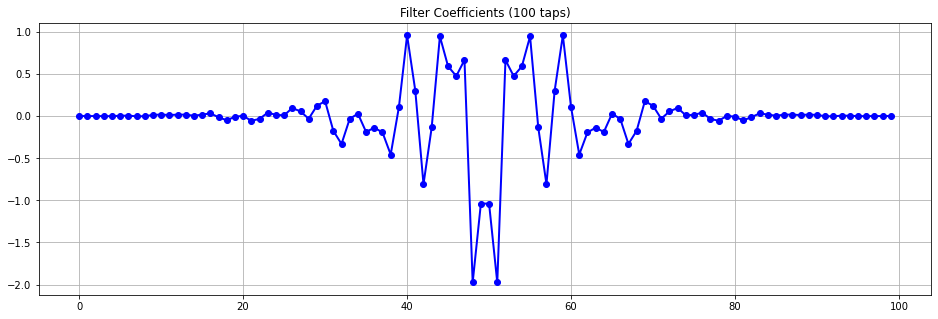

In [16]:
def plot_fir(taps):
    plt.figure(1, figsize=(16,5))
    plt.plot(taps, 'bo-', linewidth=2)
    plt.title('Filter Coefficients (%d taps)' % len(taps))
    plt.grid(True)

plot_fir(taps)

*The number of taps was chosen experimentally, so that the left and right side of the filter only has negligible values.*

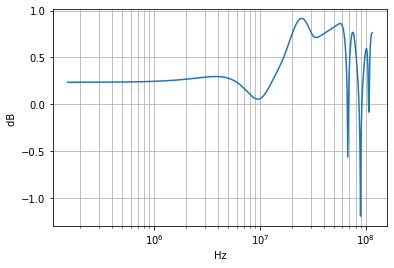

In [17]:
def plot_fir_response(taps):
    _, ax = plt.subplots()
    freq, response = scipy.signal.freqz(taps, worN=np.logspace(np.log10(min_frequency), np.log10(max_frequency), 500, base=10), fs=iff_sf)
    ax.semilogx(0.5*iff_sf*freq/np.pi, np.log10(np.abs(response)))[0]
    ax.grid(b=True, which='both')
    ax.set(xlabel="Hz", ylabel="dB ")

plot_fir_response(taps)

# The Sound Meter

## Pre-processing the audio file

In [18]:
filtered_iff = scipy.signal.lfilter(taps, 1.0, iff[0])

## Review the original audio

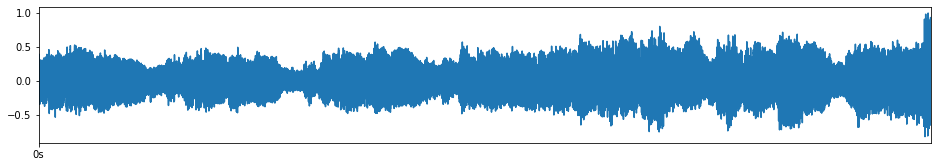

In [19]:
plot_waveform(iff[0], iff_sf)

In [20]:
play(iff[0], normalize=True)

## Compare to the filtered audio

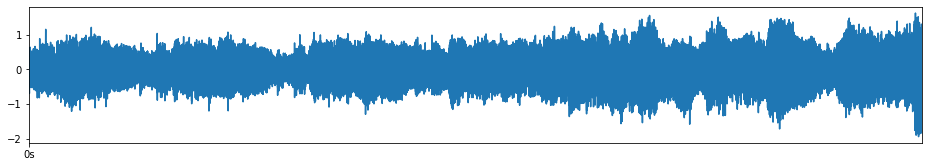

In [21]:
plot_waveform(filtered_iff, iff_sf)

In [22]:
play(filtered_iff, normalize=True)

## Measure sound levels

In [23]:
# copied form https://github.com/prandoni/COM418/blob/main/AudioMetrics/AudioMetrics.ipynb

def analog_meter(x, rise, fall):
    ppm = np.r_[0, (x * x)[:-1]]
    for n in range(1, len(x)):
        a = rise if ppm[n] > ppm[n-1] else fall
        ppm[n] = a * ppm[n] + (1 - a) * ppm[n-1]
    return np.sqrt(ppm)

def vu_meter(x, c=0.001):
    return analog_meter(x, rise=c, fall=c)

In [24]:
input_c = widgets.FloatText(value=0.001)
display(widgets.HBox([
    widgets.Label('Leaky integrator coefficient: ',layout=widgets.Layout(width='180px')),
    input_c
]))

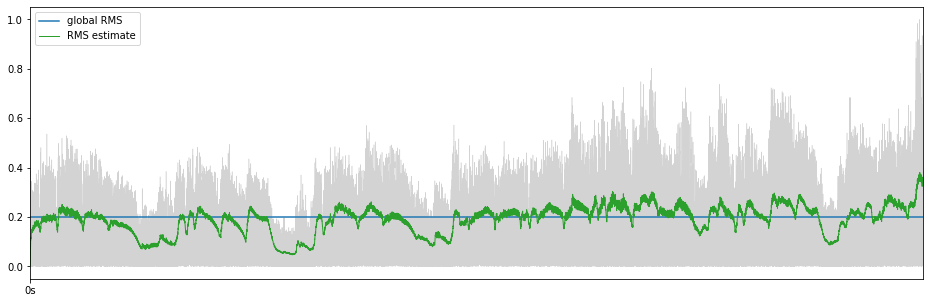

In [25]:
def plot_rms(clip, c):
    global_rms = np.sqrt(np.mean(clip * clip))
    
    plt.figure(figsize=(16,5))
    plt.plot(np.abs(clip), color='lightgray', linewidth=0.5)
    plt.axhline(y=global_rms, color='C0', label='global RMS')
    plt.plot(vu_meter(clip), color='C2', linewidth=1, label='RMS estimate')
    ax1 = plt.gca()
    ax1.set_xticks(np.arange(0, iff.shape[0], iff_sf*30))
    ax1.set_xticklabels(list(map(lambda t: "{:.0f}s".format(t), np.arange(0, iff.shape[0]/iff_sf, 30))))
    ax1.set_xlim((0, len(clip)))
    plt.legend()

plot_rms(iff[0], c=input_c.value)

In [26]:
input_lufs_window = widgets.FloatText(value=0.4)
display(widgets.HBox([
    widgets.Label('LUFS window length (in seconds): ',layout=widgets.Layout(width='220px')),
    input_lufs_window
]))

In [27]:
# parts copied form https://github.com/prandoni/COM418/blob/main/AudioMetrics/AudioMetrics.ipynb

def LUFS(x, block_length, sf=DEFAULT_SF):
    y = np.square(x)
    # compute RMS for each block
    step = int(sf * block_length / 4)  # analysis blocks are 400 ms, with 75% overlap, so step is 100 ms
    block_size = 4 * step   
    z = np.zeros(len(x) // step)
    for n in range(0, len(z)):
        z[n] = np.mean(y[(n * step):(n * step + block_size)])

    # integrated LUFS: compute the data-dependent threshold
    gamma_r = np.mean(z[z > 0.0000001]) / 10  # kill everything under -70 dB
    lufs_i = np.mean(z[z > gamma_r])
    
    return 10 * np.log10(lufs_i)

In [28]:
lufs_original = LUFS(iff[0], block_length=input_lufs_window.value)
print("LUFS of the original audio: {:.2f}".format(lufs_original))
lufs_filtered = LUFS(filtered_iff, block_length=input_lufs_window.value)
print("LUFS of the filtered audio: {:.2f}".format(lufs_filtered))

LUFS of the original audio: -13.84
LUFS of the filtered audio: -8.52
